In [1]:
import argparse, pydicom
import torch
import numpy as np

from pathlib import Path
from typing import Any, Dict, Iterable, Tuple, List
from omegaconf import DictConfig, OmegaConf

import tg43.dicom_helper as dhelp
import tg43.contour_helper as chelp
import tg43.dose_calculation as dosecal
import tg43.utils as utils
import tg43.visualization as vis

ModuleNotFoundError: No module named 'src.logging_utils'

In [ ]:
def load_hyperparams(config_path: Path) -> Tuple[DictConfig, Dict]:
    """Load MCO-IPSA hyperparameters from YAML and resolve runtime types."""

    cfg = OmegaConf.load(config_path)
    cfg_dict = OmegaConf.to_container(cfg, resolve=True)  # type: ignore[arg-type]
    return cfg

def resolve_single(path_iterable: Iterable[Path], description: str) -> Path:
    """Return the first path from ``path_iterable`` or raise if empty."""

    candidates = sorted(path_iterable)
    if not candidates:
        raise FileNotFoundError(f"No files found for {description}.")
    return candidates[0]

def load_case_paths(root: Path, case_id: int) -> Dict[str, Path]:
    """Collect CT, RTDOSE, RTPLAN, and RTSTRUCT paths for a case."""

    case_dir = root / f"{case_id}"
    if not case_dir.exists():
        raise FileNotFoundError(f"Case directory not found: {case_dir}")

    return {
        "ct": resolve_single(case_dir.glob("CT*/*"), "CT series"),
        "dose": resolve_single(case_dir.glob("RTDOSE*/*/*.dcm"), "RTDOSE file"),
        "plan": resolve_single(case_dir.glob("RTPLAN*/*/*.dcm"), "RTPLAN file"),
        "struct": resolve_single(case_dir.glob("RTSTRUCT*/*/*.dcm"), "RTSTRUCT file"),
    }

In [ ]:
cfg = load_hyperparams(Path("config.yaml"))
cfg

{'hyperparams': {'anisotropy_table': './ESTRO/nucletron_mhdr-v2_F.xlsx', 'radial_table': './ESTRO/nucletron_mhdr-v2_gL.xlsx', 'dose_max_cgy': 6000}, 'models': {'dinov3': 'facebook/dinov3-vitb16-pretrain-lvd1689m'}, 'run': {'data-root': '/mnt/d/PRV/GYN_Geneva_wo_Needles', 'case': 'Case6'}}

In [ ]:
data_root = Path(cfg['run']['data-root'])
case_id = Path(cfg['run']['case'])
print(f"Data root: {data_root}")
print(f"Case ID: {case_id}")
paths = load_case_paths(data_root, case_id)
paths

Data root: /mnt/d/PRV/GYN_Geneva_wo_Needles
Case ID: Case6


{'ct': PosixPath('/mnt/d/PRV/GYN_Geneva_wo_Needles/Case6/CT_0_20240112/series_3_1.3.6.1.4.1.2452.6.1088874395.1296847118.3536313259.1264601617'),
 'dose': PosixPath('/mnt/d/PRV/GYN_Geneva_wo_Needles/Case6/RTDOSE_0_20240112/series_1_1.3.6.1.4.1.2452.6.2542691449.1298947939.3638676387.3704138358/ima_unknown_uid_1.3.6.1.4.1.2452.6.1444471091.1123319702.4073412502.1826252067.dcm'),
 'plan': PosixPath('/mnt/d/PRV/GYN_Geneva_wo_Needles/Case6/RTPLAN_0_20240112/series_1_1.3.6.1.4.1.2452.6.1356188019.1134003628.1522809736.1180775174/ima_empty_uid_1.3.6.1.4.1.2452.6.3162210145.1093853173.1113596587.2422958571.dcm'),
 'struct': PosixPath('/mnt/d/PRV/GYN_Geneva_wo_Needles/Case6/RTSTRUCT_0_20240112/series_1_1.3.6.1.4.1.2452.6.3775943779.1152257382.1983088276.1409971453/ima_empty_uid_1.3.6.1.4.1.2452.6.3039571248.1233624635.2885846168.1640366842.dcm')}

In [ ]:
# CT
ct_image, ct_array, ct_metadata = dhelp.load_ct_volume(paths["ct"])

# RTDOSE
dose_image, dose_array, dose_metadata = dhelp.load_rtdose_volume(paths['dose'])
dose_image_r, dose_array_r, dose_metadata_r = dhelp.resample_to_reference(dose_image, ct_image)

# RTPLAN
rt_channels = dhelp.load_rtplan_by_channel(paths["plan"])

# RTSTRUCT
rtstruct = chelp.load_rtstruct(paths["struct"])

In [ ]:
ct_array

array([[[-1024, -1024, -1024, ..., -1024, -1024, -1024],
        [-1024, -1024, -1024, ..., -1024, -1024, -1024],
        [-1024, -1024, -1024, ..., -1024, -1024, -1024],
        ...,
        [-1024, -1024, -1024, ..., -1024, -1024, -1024],
        [-1024, -1024, -1024, ..., -1024, -1024, -1024],
        [-1024, -1024, -1024, ..., -1024, -1024, -1024]],

       [[-1024, -1024, -1024, ..., -1024, -1024, -1024],
        [-1024, -1024, -1024, ..., -1024, -1024, -1024],
        [-1024, -1024, -1024, ..., -1024, -1024, -1024],
        ...,
        [-1024, -1024, -1024, ..., -1024, -1024, -1024],
        [-1024, -1024, -1024, ..., -1024, -1024, -1024],
        [-1024, -1024, -1024, ..., -1024, -1024, -1024]],

       [[-1024, -1024, -1024, ..., -1024, -1024, -1024],
        [-1024, -1024, -1024, ..., -1024, -1024, -1024],
        [-1024, -1024, -1024, ..., -1024, -1024, -1024],
        ...,
        [-1024, -1024, -1024, ..., -1024, -1024, -1024],
        [-1024, -1024, -1024, ..., -1024, -10

In [ ]:
# CT
ct_image, ct_array, ct_metadata = dhelp.load_ct_volume(paths["ct"])

# RTDOSE
dose_image, dose_array, dose_metadata = dhelp.load_rtdose_volume(paths['dose'])
dose_image_r, dose_array_r, dose_metadata_r = dhelp.resample_to_reference(dose_image, ct_image)

# RTPLAN
rt_channels = dhelp.load_rtplan_by_channel(paths["plan"])

# RTSTRUCT
rtstruct = chelp.load_rtstruct(paths["struct"])

In [ ]:
import copy
from typing import List


def map_channel_dwell_indices(channels, dwell_points):
    """Return flattened dwell indices for every RTPLAN channel."""

    mapping = []
    dwell_idx = 0
    for channel in channels:
        channel_indices = []
        for pos in channel.positions_cm:
            if pos is None:
                continue
            if dwell_idx >= len(dwell_points):
                raise ValueError("Flattened dwell list shorter than RTPLAN topology.")
            channel_indices.append(dwell_idx)
            dwell_idx += 1
        mapping.append(channel_indices)
    if dwell_idx != len(dwell_points):
        raise ValueError("Flattened dwell list longer than RTPLAN topology.")
    return mapping


def _normalise_distribution(values, target_sum):
    weights = np.asarray(values, dtype=float)
    weights = np.where(np.isfinite(weights) & (weights > 0.0), weights, 0.0)
    if weights.sum() <= 0.0:
        weights = np.ones_like(weights)
    weights = weights / weights.sum()
    return weights * target_sum


def adjust_channel_dwells(
    rt_channels,
    *,
    mode="perturb",
    noise_scale=1.0,
):
    """Return a copy of ``dwell_points`` with channel-wise dwell times adjusted."""

    strengths: List[float] = []
    for channel in rt_channels:
        vals = channel.strengths_U
        if vals.size:
            strengths.extend(float(v) for v in vals if np.isfinite(v) and v > 0.0)
    default_strength_U = float(np.mean(strengths)) if strengths else 30_000.0

    dwells, _ = dosecal.dwells_from_records(rt_channels, default_strength_U=default_strength_U)
    channel_indices = map_channel_dwell_indices(rt_channels, dwells)

    updated = copy.deepcopy(dwells)

    for indices in channel_indices:
        if not indices:
            continue

        base = np.array([dwells[i].dwell_time_s for i in indices], dtype=float)
        total = float(base.sum())
        if total <= 0.0:
            continue

        if mode == "perturb":
            noise = np.random.normal(loc=0.0, scale=noise_scale, size=base.size)
            proposal = base * (1.0 + noise)
        elif mode == "random":
            proposal = np.random.normal(loc=0.0, scale=noise_scale, size=base.size)
        else:
            raise ValueError(f"Unknown dwell adjustment mode: {mode}")

        scaled = _normalise_distribution(proposal, total)
        for idx, dwell_idx in enumerate(indices):
            updated[dwell_idx].dwell_time_s = float(scaled[idx])

    dosecal.rebuild_channels(rt_channels, updated)
    return dosecal.rebuild_channels(rt_channels, updated)

In [ ]:
rtdose_original = dosecal.calculate_and_resample_to_ct(
    ct_image=ct_image,
    channels=rt_channels,
    anisotropy_path=cfg["hyperparams"]["anisotropy_table"],
    radial_path=cfg["hyperparams"]["radial_table"],
    grid_spacing_mm=ct_image.GetSpacing(),
    margin_mm=20.0,
    max_distance_cm=10.0,
)

vis.plot_dose_distribution(
    ct_array, 
    rtdose_original.resampled_array, 
    ct_metadata,
    dose_max=hyperparams["dose_max_cgy"]
)

NameError: name 'hyperparams' is not defined

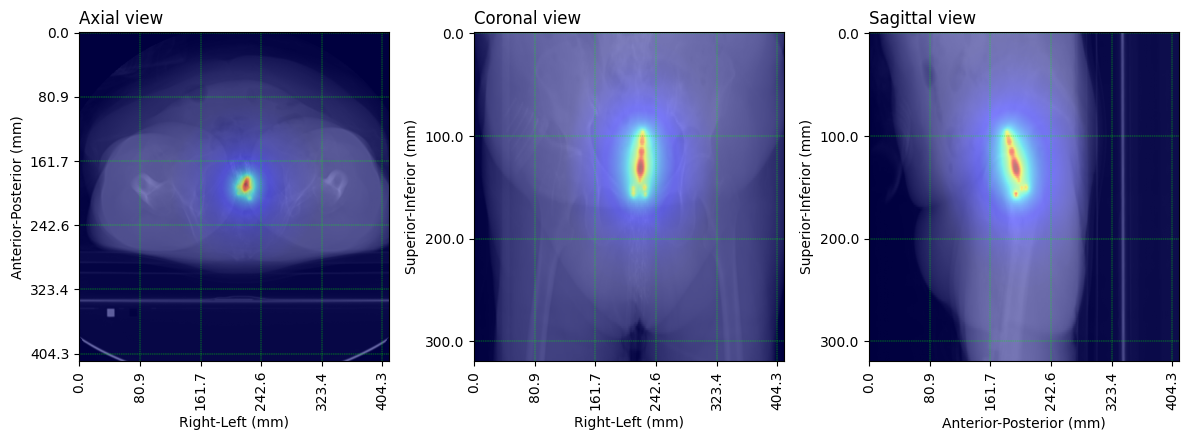

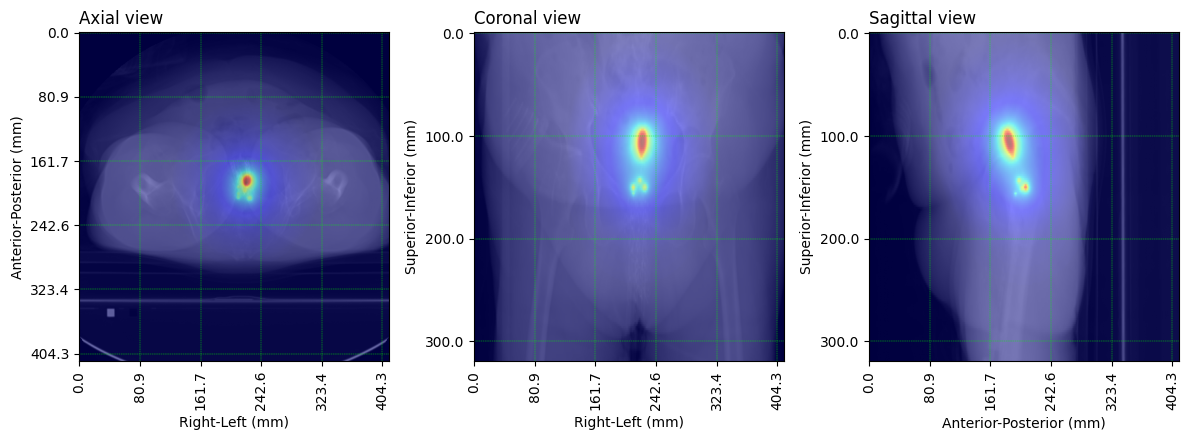

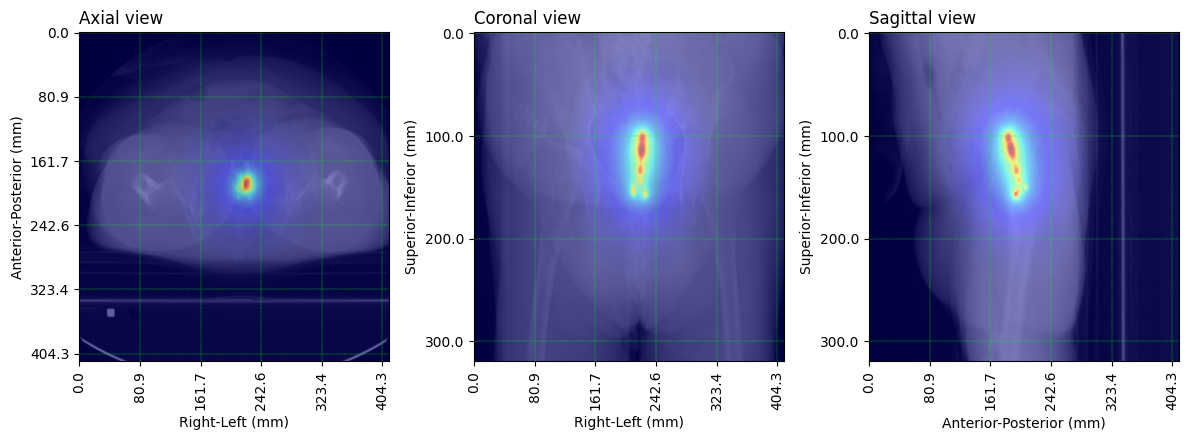

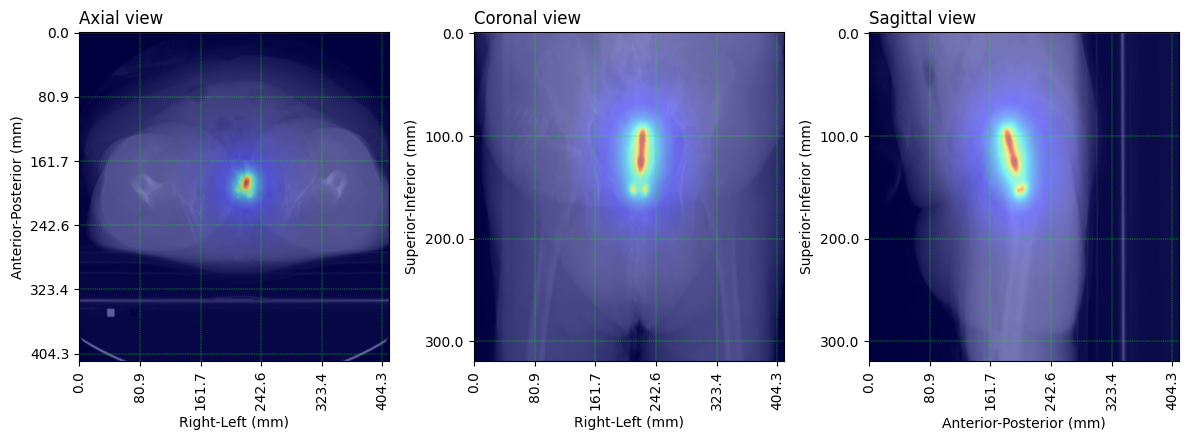

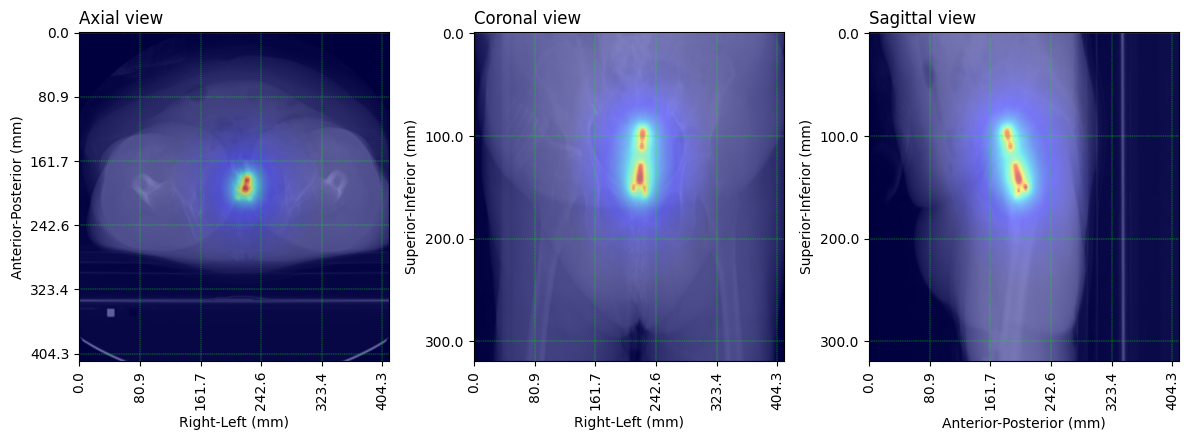

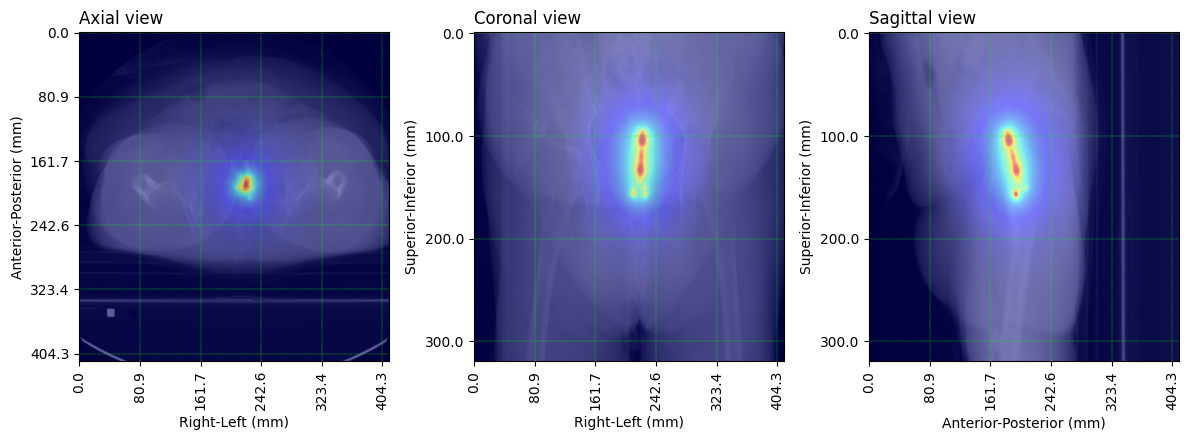

In [ ]:
for idx_iter in range(6):
    if idx_iter < 3:
        dwell_adjustment_mode = "perturb"  # Options: None, "perturb", "random"
    else:
        dwell_adjustment_mode = "random"  # Options: None, "perturb", "random"
    dwell_noise_scale = 1           # Std-dev for multiplicative noise (only for "perturb")

    rt_channels_new = adjust_channel_dwells(
        rt_channels=rt_channels,
        mode=dwell_adjustment_mode,
        noise_scale=dwell_noise_scale,
    )

    rtdose_new = dosecal.calculate_and_resample_to_ct(
        ct_image=ct_image,
        channels=rt_channels_new,
        anisotropy_path=cfg["hyperparams"]["anisotropy_table"],
        radial_path=cfg["hyperparams"]["radial_table"],
        grid_spacing_mm=ct_image.GetSpacing(),
        margin_mm=20.0,
        max_distance_cm=10.0,
    )

    vis.plot_dose_distribution(
        ct_array, 
        rtdose_new.resampled_array, 
        ct_metadata,
        dose_max=cfg["hyperparams"]["dose_max_cgy"]
    )

In [ ]:
import numpy as np
for _ in range(3):
    print(np.random.normal(loc=0.0, scale=1, size=5))

[-0.82355166  1.15113275 -0.92337022  0.62860919  1.71257729]
[ 0.45863429 -0.86048539  0.25187436  0.20939821  0.40039708]
[ 2.42110658 -0.02508152  0.58722491  0.00811294 -2.10963706]
